# Méthodes de Base pour Benchmark  data ECG



Chaque enregistrement est constitué des enregistrements de 12 capteurs, sur 4096 pas de temps.

La grande dimension de l'espace des features (4096 x 12 = 49152) est contournée classiquement par une Principal Component Analysis, dont on retiendra dans la plupart des modèles les 50 premières composantes, afin d'avoir des temps de calcul raisonnables sur PC.

Le dataset est fortement déséquilibré, avec 136 examens comportant au moins une pathologie, et 691 n'en comportant aucune.

Cette proportion est suffisante pour entrainer de très mauvais résultats sur un algorythme de LR classique effectué sans précaution : si la précision est bonne (>85%), elle n'est due qu'au fait que le modèle classe systématiquement les points du test set en classe 0 (sans pathologie).

On revoit dans un premier temps l'objectif : maximiser la détection des pathologies, quitte à dégrader les autres metrics. C'est à ce stade ce qui peut paraître le plus prioritaire en terme de santé publique.

Deux techniques sont utilisées pour essayer de gérer le déséquilibre du dataset : les 'weighted classes' (cad l'affectation de poids important aux classes 1 relativement aux classes 0), et l''undersampling' (cad la constitution d'un training set réduit comportant à parts égales des classes 0 et des classes 1).

Un autre algorythme est utilisé : le SVM, avec un Kernel Gaussien classique, dans l'espoir de capturer un peu de non-linéarité dans l'espace de départ.

C'est globalement la méthode des poids qui obtient les meilleurs résultats, avec 8 ECGs pathologiques détectés sur 13 pour la LR, et 9/13 pour le SVM.

L'undersampling semble moins bien performer, avec respectivement 14/30 détectés en LR, 8/30 en SVM. Mais sur un test set plus grand.

En annexe, sans surprise, les essais en multi-classes (en ditinguant les différentes pathologies) butent sur le même écueil, le déséquilibre des classes, encore plus aïgu dans le cas des multi-class.

Le notebook utilise le fichier 'ecg_tracings.hdf5', qui doit se trouver dans le même directory que le fichier

Import Bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import scipy
from scipy import stats
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

Import Data

In [2]:
# data brute, 827 samples x (taille 4096 x 12 signaux)
import h5py
f = h5py.File('ecg_tracings.hdf5', 'r')
data_brute = list(f['tracings'])

In [3]:
# Définit les pathologies : il y en a 6
diagnosis = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']
# Récupère les pathologies définies dans le 'gold standard' (deux cardiologistes + un troisième si désaccord)
y_gold_standard = pd.read_csv('gold_standard.csv').values

## Analyse exploratoire des données :

Le fichier y_gold_standard est retenu ici. Il indique pour chaque point parmis les 827 de l'échantillon, quelle(s) pathologies sont éventuellement présentes.

In [4]:
print(f"Nombre total pathologies détectées = {y_gold_standard.sum()} sur {len(y_gold_standard)}")
count_pathologies = list(np.sum(y_gold_standard,axis=1))
print(f"Examens sans pathologie = {count_pathologies.count(0)}")
print(f"Examens avec une pathologie = {count_pathologies.count(1)}")
print(f"Examens avec deux pathologies = {count_pathologies.count(2)}")
type_pathologies = np.sum(y_gold_standard,axis=0)
for t in enumerate (diagnosis) :
    print (diagnosis[t[0]], type_pathologies[t[0]])

Nombre total pathologies détectées = 158 sur 827
Examens sans pathologie = 681
Examens avec une pathologie = 134
Examens avec deux pathologies = 12
1dAVb 28
RBBB 34
LBBB 30
SB 16
AF 13
ST 37


### Analyse de dimensionnalité sur l'espace des features.

Chaque examen parmis les 827, est un set de 12 enregistrements de 4096 points.

Un datapoint a donc 12 x 4096 = 49152 dimensions.

On va faire une Principal Component Analysis pour déterminer si on peut faire tourner le modèle sur un espace de dimension plus faible

Petit mémo sur le reshape :

In [5]:
test = np.array([[[0,1,2,3],[4,5,6,7]],
                [[2,3,6,7],[8,9,0,0]]])
print(test)

[[[0 1 2 3]
  [4 5 6 7]]

 [[2 3 6 7]
  [8 9 0 0]]]


In [6]:
print(np.reshape(test,(2,8)))  

[[0 1 2 3 4 5 6 7]
 [2 3 6 7 8 9 0 0]]


In [7]:
print(np.reshape(test,(2,8),order='C'))  # ordre par défaut

[[0 1 2 3 4 5 6 7]
 [2 3 6 7 8 9 0 0]]


In [8]:
print(np.reshape(test,(2,8),order='F'))

[[0 4 1 5 2 6 3 7]
 [2 8 3 9 6 0 7 0]]


De retour sur notre 827 x 4096 x 12

In [9]:
data = np.asarray(data_brute)
data.shape

(827, 4096, 12)

In [10]:
#####################################################################
#### on va donc agréger les 12 capteurs par pas de temps, ###########
#### puis passer au pas de temps suivant ############################
#####################################################################

data = np.reshape(data,(827,4096*12),order='C')

In [11]:
data.shape

(827, 49152)

Le PCA nécessite que les features soient normalisées

In [12]:
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)
data_norm.shape

(827, 49152)

Le PCA revient à calculer les valeurs propres de la matrice de la covariance empirique. C'est une matrice de taille nombre_échantillons x nombre_échantillons, symétrique positive. Une valeur propre indique la part de la variance de l'échantillon qui est expliquée par la projection sur le vecteur propre associé.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [13]:
n_comp = 40 # on peut prendre jusqu'à 827, le nombre de points
pca = PCA(n_components=n_comp)
pca.fit(data_norm)
explained = pca.explained_variance_ratio_

Nombre de composantes principales = 40
Variance expliquée = 89.8%


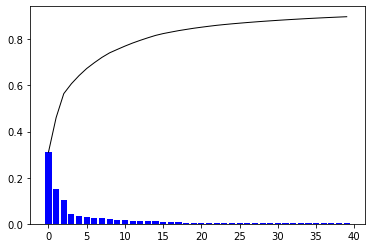

In [14]:
x = list(range(0,n_comp))
exp = list(explained)
cumul = np.zeros(n_comp)
cumul[0]=explained[0]
for i in range(1,len(explained)):
    cumul[i]=cumul[i-1]+explained[i]
print(f"Nombre de composantes principales = {n_comp}")
print(f"Variance expliquée = {round(explained.sum()*100,1)}%")
plt.bar (x, exp, color = 'blue', label = 'x' )  # charte simple
plt.plot (x, cumul, color = 'black', linewidth = 1)

### Conclusion de la PCA :
On voit par exemple ici qu'on pourrait retenir 40 composants pour 90% de la variance,
130 composants pour 95% de la variance, et donc 827 pour 100%.

## Construction du vecteur des labels

In [15]:
y_gold_standard

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=int64)

In [16]:
y_gold_standard.shape

(827, 6)

Labels : on classe simplement entre "pas de pathologie" et "au moins une pathologie"

In [17]:
y_labels = np.array(range(len(y_gold_standard)))
for i,tab in enumerate(y_gold_standard):
    y_labels[i] = (1 if tab.sum()>=1 else 0)

In [18]:
y_labels.shape

(827,)

Split entre Train et Test

In [19]:
# 10% du sample gardé pour les tests (soit 82 points)
# random state = 0 assure que le shuffling sera le même lors des tests et debugs
X_train, X_test, y_train, y_test = train_test_split(
    data, y_labels, test_size=0.10, random_state=0)

In [20]:
X_train.shape

(744, 49152)

In [21]:
X_test.shape

(83, 49152)

# MODELE 1 - Baseline : Logistic Regression binaire

Construction du Pipeline Logistic Regression

Normalisation par Standard Scaler, puis PCA, puis Logistic Regression classique.

In [22]:
#1 - Normalisation
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler
norm = StandardScaler()
#2 - PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
red_dim = PCA(n_components=50) # nombre de composants à définir
#3 - Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr = LogisticRegression(penalty = 'l2',  # regularisation : L2 par défaut, ou 'None' pour voir sans
                        solver = 'lbfgs',   # 'sag' = stochastic gradient descent, 'lbfgs' par défaut
                        tol = 0.1,  # on converge mal avec la tolérance par défaut 10^-4
                        max_iter = 1000   # on augmente le nombre d'itérations pour avoir la convergence
                       )

In [23]:
estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('regression_logistique', lr)]
               
baseline_lr = Pipeline(estimators)

### Première méthode pour évaluer le modèle : train/test split

In [24]:
def eval_1 (modele, X_train, y_train, X_test, y_test):
    # fit le modèle,
    # prédit sur le test set
    # calcule le score sur le test set
    # printe le rapport et la confusion matrix
    modele.fit(X_train, y_train)
    y_pred = modele.predict(X_test)
    score = modele.score(X_test,y_test)
    print("Score modèle = ", score)
    print("Classification Report :")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix sur le test set :")
    sklearn.metrics.plot_confusion_matrix(modele, X_test, y_test)
    plt.show()

Score modèle =  0.8554216867469879
Classification Report :
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        70
           1       1.00      0.08      0.14        13

    accuracy                           0.86        83
   macro avg       0.93      0.54      0.53        83
weighted avg       0.88      0.86      0.80        83

Confusion matrix sur le test set :


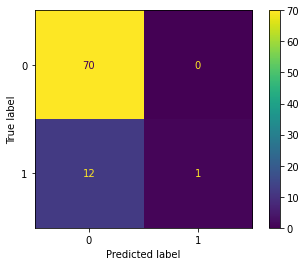

In [25]:
eval_1(baseline_lr, X_train, y_train, X_test, y_test)

### Deuxième méthode pour évaluer la précision : Cross-Validation

On utilise seulement le training set bien sûr, pas le set entier.

In [26]:
def eval_2 (modele, X_train, y_train, nb_cv=3):
    # fait une cross-validation (par défaut 3 folds)
    # affiche les résultats de la CV,
    # calcule une prédiction sur le training set
    # sort la confusion matrix sur le train set et le test set
    print ("cross-validation")
    results_cv = cross_val_score(modele, X_train, y_train, cv=3)
    print ("scores = ",results_cv)
    print ("moyenne = ",results_cv.mean())
    print ("ecart type = ",results_cv.std())
    y_train_pred = cross_val_predict(modele, X_train, y_train, cv=nb_cv)
    print("Confusion matrix sur le train set :")
    print(confusion_matrix(y_train, y_train_pred))
    plt.show()

In [27]:
eval_2 (baseline_lr, X_train, y_train)

cross-validation
scores =  [0.80645161 0.82258065 0.76612903]
moyenne =  0.7983870967741935
ecart type =  0.02374129265141896
Confusion matrix sur le train set :
[[588  23]
 [124   9]]


## Une discussion sur les metrics s'impose :

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

https://en.wikipedia.org/wiki/Precision_and_recall

https://en.wikipedia.org/wiki/Confusion_matrix

- score du modèle/accuracy : c'est la proportion de bonnes prédictions, cad
nombre_prédictions_correctes / nombre_de_prédictions_totales
on voit que sur le test set, on a 70 classes 0, et 13 classes 1. Un modèle qui donne systématiquement la classe 0, va donc mécaniquement avoir 70/83 = 84,34% précision, sans être un bon modèle. Attention...

- precision (1ere colonne) : c'est tp / (tp + fp) ; la proportion de vrais positifs dans l'ensemble des positifs prédits par le modèle. Dans notre cas, un positif est la classe 0 (pas de pathologie). 85% des positifs donnés par le modèle sont de vrais positifs.

- recall (2e colonne) : c'est tp / (tp + fn) ; la proportion de positifs rééls détectés par le modèle.

- le F1-score est la moyenne harmonique des deux : 2 x (precision x recall) / (precision + recall)

Les metrics sont calculés pour chaque classe par la fonction classification_report.
On voit que :

- pour la classe 0, precision = 0.85 et recall = 1 : tous les ECG sans pathologie sont détectés (recall=1), mais seules 85% des prédictions de classe 0 (=ECG sans pathologie) sont justes !
- pour la classe 1, precision = 1 : tous les ECG avec pathologie prédits par le modèle sont de vrais ECGs avec pathologie, mais recall = 0,08 : la proportion d'ECG avec pathologie détectés est très faible : 1/13 !

On déduit que le modèle a prédit une classe 1, correcte, et le reste en classe 0, dont 70 prédictions correctes. On retrouve la précision de (70 + 1)/(70 +13) = 85,5%. 12 classes 1 n'ont donc pas été détectées.

### Le modèle n'est donc pas bon, malgré une précision élevée

#### Objectif : on va chercher un recall de classe 1 élevé, cad une forte détection des ECG indiquant une pathologie, même si cela mène à la dégradation des autres metrics.

### Recherche de la courbe Precision-Recall

In [28]:
def courbes(modele, X_train, y_train, nb_cv=3):
    y_scores = cross_val_predict(modele, X_train, y_train, cv=nb_cv, method='decision_function')
    # method='decision_function' appelle la méthode de LogisticRegression qui retourne les probabilités, pas la classe
    precisions, recalls, seuils = precision_recall_curve(y_train, y_scores)
    print("Courbe précision vs recall")
    plt.plot(seuils, precisions[:-1], 'b--', label = "Precision")
    plt.plot(seuils, recalls[:-1], 'g-', label = "Recall")
    plt.legend()
    plt.show()
    print("ROC")
    fpr, tpr, seuils = roc_curve(y_train, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0,1],[0,1],'k--')
    plt.grid
    plt.show()

Courbe précision vs recall


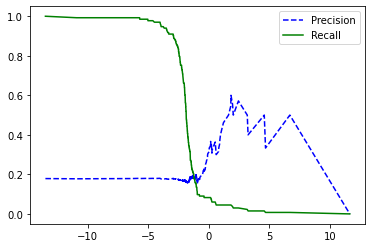

ROC


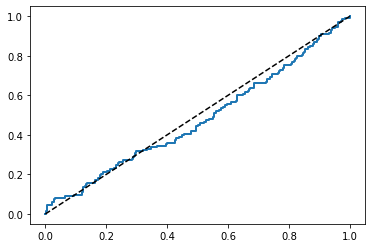

In [29]:
courbes(baseline_lr, X_train, y_train)

On voit que l'on pourrait avoir un recall autour de 90% avec une précision d'environ 20%.

NB : la petitesse du dataset provoque des courbes assez bizarres

Ce qui confirme si besoin en était que le classifier est très mauvais.

# MODELE 2 - Logistic Regression Binaire avec weighted classes

On introduit des poids sur la classe '1' (pathologie) sous représentée, dans l'espoir de mieux entrainer le modèle.

In [30]:
#1 - Normalisation
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler
norm = StandardScaler()
#2 - PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
red_dim = PCA(n_components=50) # nombre de composants à définir
#3 - Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# poids = 5  # poids affecté aux classes faiblement représentées (avec pathologie). 
            # Le score s'écroule si le poids est trop haut.
# poids_classes = {0:1, 1:poids}
lr = LogisticRegression(penalty = 'l2',  # regularisation : L2 par défaut, ou 'None' pour voir sans
                        solver = 'lbfgs',   # 'sag' = stochastic gradient descent, 'lbfgs' par défaut
                        tol = 0.1,  # on converge mal avec la tolérance par défaut 10^-4
                        max_iter = 2000,   # on augmente le nombre d'itérations pour avoir la convergence
                        class_weight = 'balanced'  # surpoids de la classe '1', 
                                                   # par défaut inversement proportionnel à la fréquence de la classe
                       )

estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('regression_logistique', lr)]
               
lr_w = Pipeline(estimators)

Score modèle =  0.6024096385542169
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.60      0.72        70
           1       0.22      0.62      0.33        13

    accuracy                           0.60        83
   macro avg       0.56      0.61      0.52        83
weighted avg       0.79      0.60      0.66        83

Confusion matrix sur le test set :


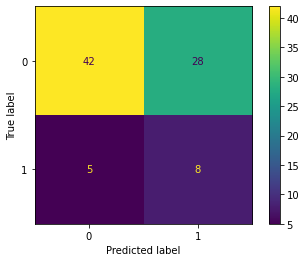

In [31]:
eval_1(lr_w, X_train, y_train, X_test, y_test)

8/13 = 62% des ECG pathologiques sont détectés (vs 8% précedemment), mais seulement 8/35 = 23% des ECGs pathologiques annoncés par le modèle sont réels.

La précision du modèle est fortement dégradée à 61% - à peine plus d'une prédiction sur deux est correcte. On ne fait pas beaucoup mieux que le pile ou face.

In [32]:
eval_2 (lr_w, X_train, y_train)

cross-validation
scores =  [0.66129032 0.68145161 0.59677419]
moyenne =  0.646505376344086
ecart type =  0.03611566893157095
Confusion matrix sur le train set :
[[442 169]
 [ 93  40]]


Courbe précision vs recall


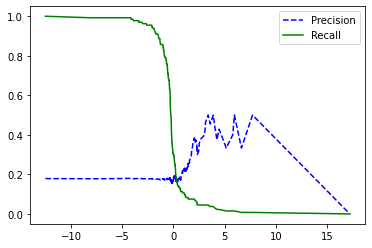

ROC


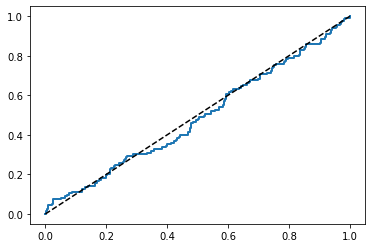

In [33]:
courbes(lr_w, X_train, y_train)

# MODELE 3 - SVM avec weighted classes

La LR Binaire trouve un hyperplan qui sépare -au mieux- les points de classe prédite 1 et les points de classe prédite -1. Les paramètres de l'hyperplan sont trouvés en applicant maximisant l'EMV, ou, ce qui revient au même, en minimisant la cross-entropy loss. (En dimension n>=2, on utilise la fonction softmax, qui est la généralisation de la fonction logistique, et qui mène à la cross-entropy loss multinomiale.)

L'algorythme SVM va aussi chercher un -ou plusieurs- hyperplan(s) de séparation des points, avec une méthode différente : il s'agit de maximiser une "marge" (=distance de séparation) entre les deux classes, en utilisant le problème dual du problème de maximisation de la marge. Le Lagrangien fait intervenir des contraintes d'inégalité, et seuls les points où la contrainte est active (les plus proches de la limite) ont des coefficients non nuls : ce sont les "support vectors".

Le SVM permet également de faire intervenir des Kernels, cad un mapping de l'espace des points de départ ("attributs") dans un espace intermédiaire de points appelés "features". Le Kernel permet de faire correspondre un problème linéaire de définition d'hyperplan(s) dans l'espace des features, à une séparation non-linéaire dans l'espace de départ.

Gros espoirs donc sur le SVM, avec on imagine un Kernel non-linéaire.

https://scikit-learn.org/stable/modules/svm.html

In [34]:
#1 - Normalisation
norm = StandardScaler() # inchangé
#2 - PCA
red_dim = PCA(n_components=50)    # on prend toutes les composantes.
#3 - Support Vector Machine
poids = 10  # poids affecté aux classes faiblement représentées (avec pathologie). 
            # Le score s'écroule si le poids est trop haut.
poids_classes = {0:1, 1:poids}
classifier = svm.SVC(C = 1.0, # coeff régularisation L2
                     kernel = 'rbf', # Gaussian Kernel, classique, 
                     # https://en.wikipedia.org/wiki/Radial_basis_function_kernel
                     gamma = 'scale', # choix paramètre du Gaussian Kernel
                     tol = 0.1,  # tolérance basse pour ne pas trop attendre
                     class_weight = poids_classes,  # permet d'affecter des poids en fonction de la fréquence des classes.
                     max_iter = 10000,   # on augmente le nombre d'itérations pour avoir la convergence
                     decision_function_shape = 'ovo', # one-versus-one classifiers en multi-classes
                     )

estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('svm', classifier)]
               
lr_svm_w = Pipeline(estimators)

Score modèle =  0.25301204819277107
Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.17      0.28        70
           1       0.13      0.69      0.23        13

    accuracy                           0.25        83
   macro avg       0.44      0.43      0.25        83
weighted avg       0.65      0.25      0.27        83

Confusion matrix sur le test set :


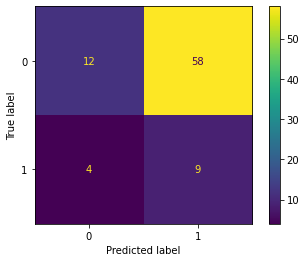

In [35]:
eval_1(lr_svm_w, X_train, y_train, X_test, y_test)

In [36]:
eval_2 (lr_svm_w, X_train, y_train)

cross-validation
scores =  [0.31451613 0.30241935 0.31854839]
moyenne =  0.3118279569892473
ecart type =  0.0068535208516031995
Confusion matrix sur le train set :
[[131 480]
 [ 30 103]]


Courbe précision vs recall


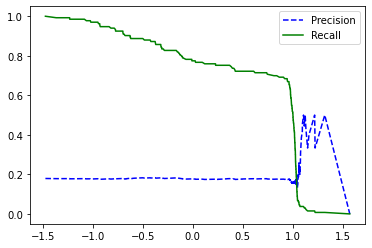

ROC


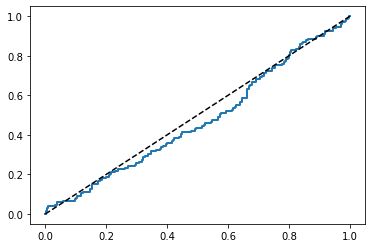

In [37]:
courbes(lr_svm_w, X_train, y_train)

Un peu mieux que la LR avec poids : 9/13 = 69% des ECG pathologiques détectés.
Mais avec beaucoup de fausses pathologies : seulement 13% des ECG pathologiques annoncés par le modèle sont réels.

## Une autre méthode dans le cas des 'unbalanced classes' : l'undersampling

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

L'idée est ici d'entrainer le modèle sur un set composé de certaines classes 1 (par exemple 80% des classes 1 du set total), et d'un nombre égal de classes 0.

Le validation set est alors composé des points et labels non choisis dans cette première étape.

Le modèle est entrainé sur un set de plus petite taille que précédemment, mais mieux équilibré.

In [38]:
pos_labels = [i for i,j in enumerate(y_labels) if j==1]  # liste des indices des points de classe 1
neg_labels = [i for i,j in enumerate(y_labels) if j==0]  # liste des indices des points de classe 0

In [39]:
len(pos_labels) / (len(pos_labels) + len(neg_labels))  
# proportion des classes 1 : 17,7% du total.
# Suffisant pour les mauvais résultats qu'on a vus !

0.17654171704957677

In [40]:
np.random.seed(0)
np.random.shuffle(pos_labels)
np.random.shuffle(neg_labels)

nb_indices = int(len(pos_labels)*.80)  # on prend 80% des classes 1 dans le training set

indices_pos = pos_labels[0:nb_indices]
indices_neg = neg_labels[0:nb_indices]

In [41]:
len(indices_pos)

116

In [42]:
train_pos = data[indices_pos]
train_neg = data[indices_neg]
X_train_resampled = np.concatenate((train_pos, train_neg), axis=0)
y_train_resampled = np.concatenate((y_labels[indices_pos], y_labels[indices_neg]))

order = np.arange(len(y_train_resampled))
np.random.shuffle(order)
X_train_resampled = X_train_resampled[order]
y_train_resampled = y_train_resampled[order]

In [43]:
X_train_resampled.shape

(232, 49152)

In [44]:
y_train_resampled.shape

(232,)

In [45]:
indices_train = np.concatenate((indices_pos, indices_neg))
indices_test = np.delete(np.arange(len(y_labels)),indices_train)
X_test_resampled = data[indices_test]
y_test_resampled = y_labels[indices_test]

In [46]:
X_test_resampled.shape

(595, 49152)

# MODELE 4 - Logistic Regression avec resampling

In [47]:
#1 - Normalisation
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler
norm = StandardScaler()
#2 - PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
red_dim = PCA(n_components=50) # nombre de composants à définir dans n_components = ...
#3 - Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr = LogisticRegression(penalty = 'l2',  # regularisation : L2 par défaut, ou 'None' pour voir sans
                        solver = 'lbfgs',   # 'sag' = stochastic gradient descent, 'lbfgs' par défaut
                        tol = 0.1,  # on converge mal avec la tolérance par défaut 10^-4
                        max_iter = 2000   # on augmente le nombre d'itérations pour avoir la convergence
                       )

In [48]:
estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('regression_logistique', lr)]
               
lr_resamp = Pipeline(estimators)

Score modèle =  0.5495798319327732
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       565
           1       0.05      0.47      0.09        30

    accuracy                           0.55       595
   macro avg       0.50      0.51      0.40       595
weighted avg       0.91      0.55      0.67       595

Confusion matrix sur le test set :


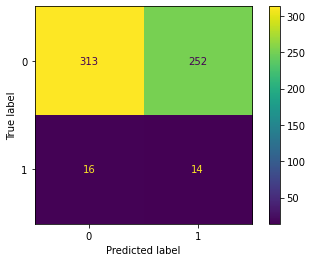

In [49]:
eval_1(lr_resamp, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled)

In [50]:
eval_2 (lr_resamp, X_train_resampled, y_train_resampled)

cross-validation
scores =  [0.6025641  0.48051948 0.42857143]
moyenne =  0.5038850038850039
ecart type =  0.07292838227735868
Confusion matrix sur le train set :
[[71 45]
 [70 46]]


Courbe précision vs recall


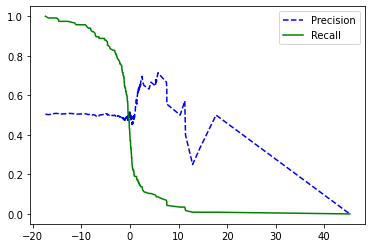

ROC


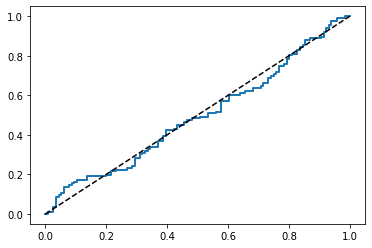

In [51]:
courbes(lr_resamp, X_train_resampled, y_train_resampled)

Seulement 14/30 = 47% des ECGs avec pathologies sont détectés. Et énormément 252/(252+14) = 95% de faux négatifs (=fausse pathologie)

# MODELE 5 - SVM avec resampling 

In [52]:
#1 - Normalisation
norm = StandardScaler() # inchangé
#2 - PCA
red_dim = PCA()    # on prend toutes les composantes.
#3 - Support Vector Machine
classifier = svm.SVC(C = 1.0, # coeff régularisation L2
                     kernel = 'rbf', # Gaussian Kernel, classique, 
                     # https://en.wikipedia.org/wiki/Radial_basis_function_kernel
                     gamma = 'scale', # choix paramètre du Gaussian Kernel
                     tol = 0.1,  # tolérance basse pour ne pas trop attendre
                     max_iter = 10000,   # on augmente le nombre d'itérations pour avoir la convergence
                     )

estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('svm', classifier)]
               
svm_resamp = Pipeline(estimators)

Score modèle =  0.7798319327731092
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       565
           1       0.07      0.27      0.11        30

    accuracy                           0.78       595
   macro avg       0.51      0.54      0.49       595
weighted avg       0.91      0.78      0.84       595

Confusion matrix sur le test set :


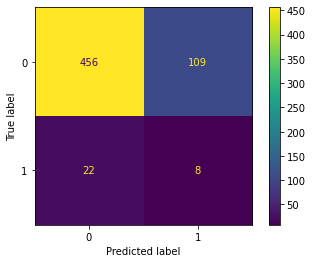

In [53]:
eval_1(svm_resamp, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled)

In [54]:
eval_2 (svm_resamp, X_train_resampled, y_train_resampled)

cross-validation
scores =  [0.48717949 0.48051948 0.45454545]
moyenne =  0.47408147408147405
ecart type =  0.014079085355273998
Confusion matrix sur le train set :
[[60 56]
 [66 50]]


Courbe précision vs recall


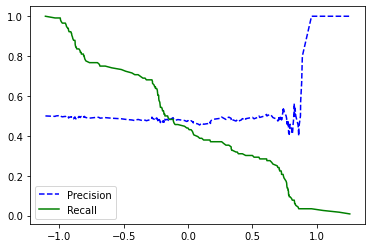

ROC


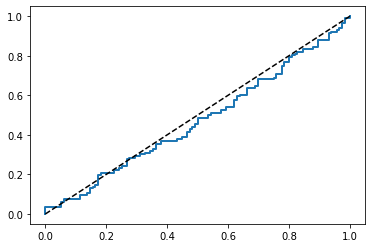

In [55]:
courbes(svm_resamp, X_train_resampled, y_train_resampled)

# CONCLUSION : 

Ce sont les modèles avec classes pondérées qui obtiennent les meilleurs résultats : LR 62% recall, 59% acc ; SVM 69% recall, 25% acc.

# ANNEXE

## Grid Search

Il y a une fonction dans scikit-learn qui permet de trouver le meilleur modèle en fonction de ses paramètres.
On la montre pour info.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [56]:
# on va chercher l'optimum en changeant :
# - nombre de composants PCA : [10,50,100,500,744]
# - type solver : ['sag','lbfgs']
# - paramètre de la régul : C [0.0001, 0.01, 1, 100, 10000]

#1 - Normalisation
norm = StandardScaler() # inchangé
#2 - PCA
red_dim = PCA() # nombre de composants à faire varier
#3 - Logistic Regression
lr = LogisticRegression(penalty = 'l2',  # regularisation : L2 par défaut
                        tol = 0.1,  # tolérance basse pour ne pas trop attendre
                        max_iter = 1000   # on augmente le nombre d'itérations pour avoir la convergence
                       )

In [57]:
estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('regression_logistique', lr)]
               
modele = Pipeline(steps=estimators)

In [58]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'reduction_dimension__n_components': [50,250,827],
    'regression_logistique__C': [0.0001, 1.0, 10000.0],
#    'regression_logistique__solver': ['lbfgs','sag'],
}

search = GridSearchCV(modele, param_grid, n_jobs=-1)
modele.get_params()

{'memory': None,
 'steps': [('normalisation', StandardScaler()),
  ('reduction_dimension', PCA()),
  ('regression_logistique', LogisticRegression(max_iter=1000, tol=0.1))],
 'verbose': False,
 'normalisation': StandardScaler(),
 'reduction_dimension': PCA(),
 'regression_logistique': LogisticRegression(max_iter=1000, tol=0.1),
 'normalisation__copy': True,
 'normalisation__with_mean': True,
 'normalisation__with_std': True,
 'reduction_dimension__copy': True,
 'reduction_dimension__iterated_power': 'auto',
 'reduction_dimension__n_components': None,
 'reduction_dimension__random_state': None,
 'reduction_dimension__svd_solver': 'auto',
 'reduction_dimension__tol': 0.0,
 'reduction_dimension__whiten': False,
 'regression_logistique__C': 1.0,
 'regression_logistique__class_weight': None,
 'regression_logistique__dual': False,
 'regression_logistique__fit_intercept': True,
 'regression_logistique__intercept_scaling': 1,
 'regression_logistique__l1_ratio': None,
 'regression_logistique__ma

In [59]:
# attention 9 minutes sur mon laptop...
# search.fit(data, y_labels)

In [60]:
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

### Validation Grid Search

In [61]:
#1 - Normalisation
norm = StandardScaler() # inchangé
#2 - PCA
red_dim = PCA(n_components = 250) # nombre de composants à faire varier
#3 - Logistic Regression
lr = LogisticRegression(penalty = 'l2',  # regularisation : L2 par défaut
                        tol = 0.1,  # tolérance basse pour ne pas trop attendre
                        max_iter = 1000,   # on augmente le nombre d'itérations pour avoir la convergence
                        solver = 'lbfgs',  # choix grid search
                        C = 0.0001 # forte régularisation
                       )

In [62]:
estimators = [('normalisation',norm),
              ('reduction_dimension', red_dim), 
              ('regression_logistique', lr)]
               
modele = Pipeline(estimators)

In [63]:
modele.fit(X_train, y_train)

Pipeline(steps=[('normalisation', StandardScaler()),
                ('reduction_dimension', PCA(n_components=250)),
                ('regression_logistique',
                 LogisticRegression(C=0.0001, max_iter=1000, tol=0.1))])

In [64]:
y_pred = modele.predict(X_test)

In [65]:
# n_comps = 250 + regul 0.0001 sortent en tête, mais le modèle performe moins bien avec 83,1% sur le test, 
# vs 85,5% plus haut
modele.score(X_test,y_test)

0.8313253012048193

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91        70
           1       0.00      0.00      0.00        13

    accuracy                           0.83        83
   macro avg       0.42      0.49      0.45        83
weighted avg       0.71      0.83      0.77        83



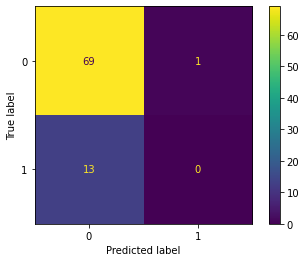

In [67]:
sklearn.metrics.plot_confusion_matrix(modele, X_test, y_test)
plt.show()